# Introduction: Feature Selection

In this notebook we will apply feature engineering to the manual engineered features built in two previous kernels. We will reduce the number of features using several methods and then we will test the performance of the features using a fairly basic gradient boosting machine model. 



The full set of features was built in [Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering) and [Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2) of Manual Feature Engineering

We will use three methods for feature selection:

1. Remove collinear features
2. Remove features with greater than a threshold percentage of missing values
3. Keep only the most relevant features using feature importances from a model



Standard imports for data science work. The LightGBM library is used for the gradient boosting machine.

In [17]:
#pip install --user featuretools

In [18]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

* `train_bureau` is the training features built manually using the `bureau` and `bureau_balance` data
* `train_previous` is the training features built manually using the `previous`, `cash`, `credit`, and `installments` data

We first will see how many features we built over the manual engineering process. Here we use a couple of set operations to find the columns that are only in the `bureau`, only in the `previous`, and in both dataframes, indicating that there are `original` features from the `application` dataframe. Here we are working with a small subset of the data in order to not overwhelm the kernel. This code has also been run on the full dataset (we will take a look at some of the results).

In [19]:
# Read in data
train_bureau = pd.read_csv('data_p7/raw/train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv('data_p7/raw/test_bureau_raw.csv', nrows = 1000)

train_previous = pd.read_csv('data_p7/raw/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('data_p7/raw/test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [20]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 122 original features.
There are 211 bureau and bureau balance features.
There are 1011 previous Home Credit loan features.


That gives us the number of features in each dataframe. Now we want to combine the data without creating any duplicate rows. 

In [21]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1344)
Testing shape:  (1000, 1343)


Next we want to one-hot encode the dataframes. This doesn't give the full features since we are only working with a sample of the data and this will not create as many columns as one-hot encoding the entire dataset would. Doing this to the full dataset results in 1465 features.

An important note in the code cell is where we __align the dataframes by the columns.__ This ensures we have the same columns in the training and testing datasets.

In [22]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 1446)
Testing shape:  (1000, 1446)


### SK_ID_CURR

When doing manual feature engineering, we created some columns derived from the client id, `SK_ID_CURR`. As this is a unique identifier for each client, it should not have any predictive power, and we would not want to build a model trained on this "feature". Let's remove any columns built on the `SK_ID_CURR`.

In [23]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (1000, 1445)
Testing shape:  (1000, 1445)


More features might seem like a good thing, and they can be if they help our model learn. However, irrelevant features, highly correlated features, and missing values can prevent the model from learning and decrease generalization performance on the testing data. Therefore, we perform feature selection to keep only the most useful variables.

We will start feature selection by focusing on collinear variables.

# Remove Collinear Variables

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold. 

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9. Again, this is not entirely accurate since we are dealing with such a limited section of the data. This code is for illustration purposes, but if we read in the entire dataset, it would work (if the kernels allowed it)! 

This code is adapted from [work by Chris Albon](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/).

### Identify Correlated Variables

In [24]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,1.000000,0.055960,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,0.055960,1.000000,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,0.036836,0.429317,1.000000,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,0.055732,0.491143,0.797209,1.000000,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,0.035851,0.439981,0.986046,0.799121,1.000000,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [25]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
CNT_CHILDREN,NaN,0.05596,0.036836,0.055732,0.035851,0.060210,0.303782,0.218535,0.211766,0.036960,...,0.096914,0.064817,0.024544,0.019465,0.005586,0.030986,0.001443,0.027967,0.004500,0.020465
AMT_INCOME_TOTAL,NaN,NaN,0.429317,0.491143,0.439981,0.184339,0.088743,0.208663,0.130682,0.045634,...,0.033574,0.064520,0.020186,0.058210,0.060465,0.080291,0.000218,0.043426,0.107476,0.030645
AMT_CREDIT,NaN,NaN,NaN,0.797209,0.986046,0.074287,0.065100,0.116515,0.027876,0.022994,...,0.005136,0.011202,0.007313,0.060005,0.009795,0.098314,0.018123,0.009507,0.075595,0.009483
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.799121,0.106685,0.019480,0.139220,0.059163,0.024020,...,0.011107,0.022890,0.017907,0.084270,0.022107,0.133969,0.036801,0.032497,0.098291,0.036308
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.073531,0.058535,0.115613,0.034500,0.030878,...,0.002397,0.020737,0.000716,0.069845,0.014077,0.094081,0.012866,0.019114,0.082543,0.000395


In [26]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 648 columns to remove.


#### Drop Correlated Variables

In [27]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (1000, 797)
Testing shape:  (1000, 797)


Applying this on the entire dataset __results in 797  collinear features__ removed.  

This has reduced the number of features singificantly, but it is likely still too many. At this point, we'll read in the full dataset after removing correlated variables for further feature selection.

The full datasets (after removing correlated variables) are available in `train_bureau_corrs_removed.csv` and `test_bureau_corrs_removed.csv`.

### Read in Full Dataset

Now we are ready to move on to the full set of features. These were built by applying the above steps to the entire `train_bureau` and `train_previous` files (you can do the same if you want and have the computational resources)!

In [28]:
train = pd.read_csv('data_p7/raw/train_bureau_corrs_removed.csv')
test = pd.read_csv('data_p7/raw/test_bureau_corrs_removed.csv')

In [29]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 199)
Testing set full shape:  (48744, 198)


In [30]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Unaccompanied,...,2.875,0.0,0.8125,1.875,3.0,0.0,0.161932,0.5,0.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Remove Missing Values

A relatively simple choice of feature selection is removing missing values. Well, it seems simple, at least until we have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 75% missing values, they will be removed. 

Most models (including those in Sk-Learn) cannot handle missing values, so we will have to fill these in before machine learning. The Gradient Boosting Machine ([at least in LightGBM](https://github.com/Microsoft/LightGBM/blob/master/docs/Advanced-Topics.rst)) can handle missing values. Imputing missing values always makes me a little uncomfortable because we are adding information that actually isn't in the dataset. Since we are going to be evaluating several models (in a later notebook), we will have to use some form of imputation. For now, we will focus on removing columns above the threshold.

In [31]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

bureau_AMT_ANNUITY_mean                           0.739817
bureau_AMT_ANNUITY_max                            0.739817
bureau_AMT_ANNUITY_min                            0.739817
client_bureau_balance_MONTHS_BALANCE_max_mean     0.700073
client_bureau_balance_MONTHS_BALANCE_count_min    0.700073
dtype: float64

In [32]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

COMMONAREA_AVG             0.687161
NONLIVINGAPARTMENTS_AVG    0.684125
FONDKAPREMONT_MODE         0.672842
FLOORSMIN_AVG              0.666051
OWN_CAR_AGE                0.662892
dtype: float64

In [33]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 0 columns with more than 75% missing values


Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.

In [34]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 319)
Testing set full shape:  (48744, 319)


In [35]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

In [1]:
#Making sure we do not have json related display bug

In [38]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [39]:
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Feature Selection through Feature Importances

The next method we can employ for feature selection is to use the feature importances of a model. Tree-based models (and consequently ensembles of trees) can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model.  The relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important. 

One method for doing this automatically is the [Recursive Feature Elimination method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) in Scikit-Learn. This accepts an estimator (one that either returns feature weights such as a linear regression, or feature importances such as a random forest) and a desired number of features. In then fits the model repeatedly on the data and iteratively removes the lowest importance features until the desired number of features is left. This means we have another arbitrary hyperparameter to use in out pipeline: the number of features to keep! 

Instead of doing this automatically, we can perform our own feature removal by first removing all zero importance features from the model. If this leaves too many features, then we can consider removing the features with the lowest importance. We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. If you're used to the Scikit-Learn library, the LightGBM library has an API that makes deploying the model very similar to using a Scikit-Learn model. 

Since the LightGBM model does not need missing values to be imputed, we can directly `fit` on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [40]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [41]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.764416	valid_0's binary_logloss: 0.535531


In [42]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
22,EXT_SOURCE_1,198.0
23,EXT_SOURCE_2,172.0
24,EXT_SOURCE_3,157.5
5,DAYS_BIRTH,142.5
2,AMT_CREDIT,126.0


In [43]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 106 features with 0.0 importance


,feature,importance
101,bureau_CREDIT_TYPE_Unknowntypeofloan_count,0.0
102,bureau_CREDIT_TYPE_Unknowntypeofloan_count_norm,0.0
108,bureau_CREDIT_DAY_OVERDUE_min,0.0
118,bureau_CNT_CREDIT_PROLONG_min,0.0
317,EMERGENCYSTATE_MODE_Yes,0.0


We see that one of our features made it into the top 5 most important! That's a good sign for all of our hard work making the features. It also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training). 

In [44]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

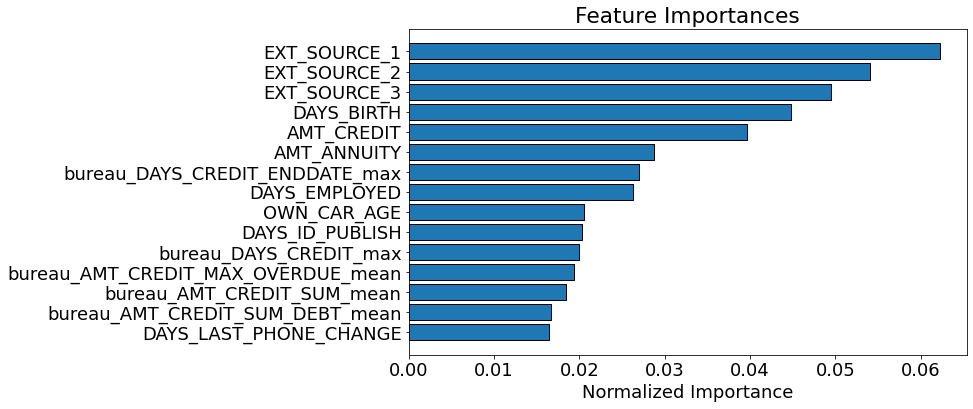

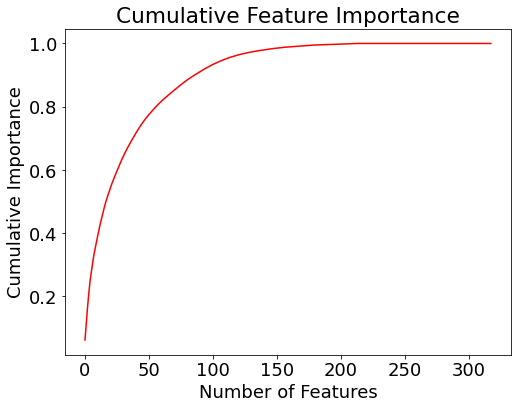

87 features required for 0.90 of cumulative importance


In [45]:
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.

In [46]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 212)
Testing shape:  (48744, 212)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [47]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [48]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

[200]	valid_0's auc: 0.762586	valid_0's binary_logloss: 0.535473
[200]	valid_0's auc: 0.763347	valid_0's binary_logloss: 0.536746

There are 0 features with 0.0 importance


There are now no 0 importance features left (I guess we should have expected this). If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. Again, this is an arbitrary decision! 

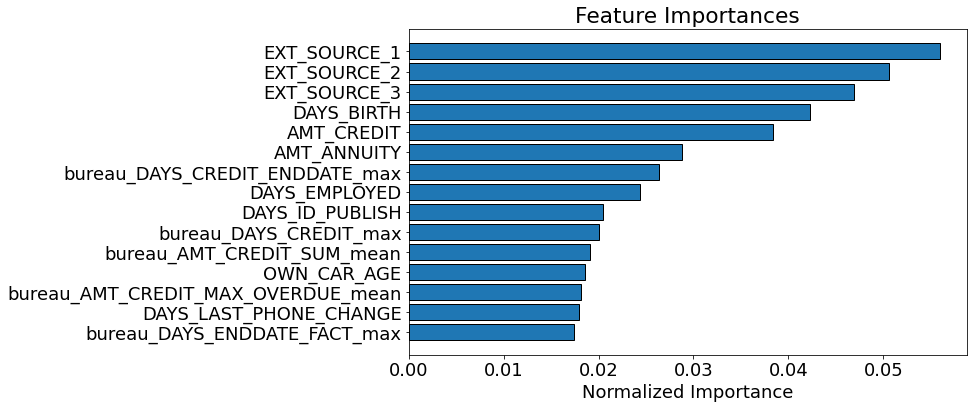

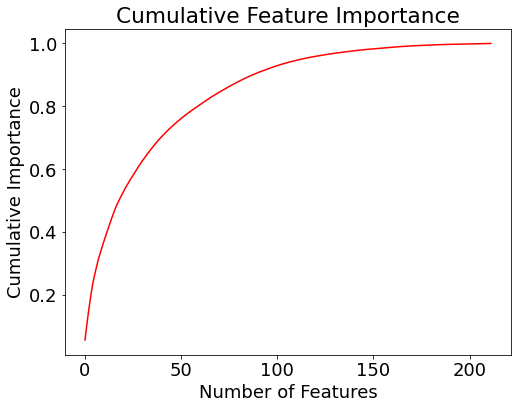

114 features required for 0.95 of cumulative importance


In [49]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. This step seems to me to have the greatest chance of harming the model's learning ability, so rather than changing the original dataset, we will make smaller copies. Then, we can test both versions of the data to see if the extra feature removal step is worthwhile. 

In [50]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [51]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('data_p7/raw/m_train_small.csv', index = False)
test_small.to_csv('data_p7/raw/m_test_small.csv', index = False)

# Test New Featuresets

The last step of feature removal we did seems like it may have the potential to hurt the model the most. Therefore we want to test the effect of this removal. To do that, we can use a standard model and change the features. 

We will use a fairly standard LightGBM model, similar to the one we used for feature selection. The main difference is this model uses five-fold cross validation for training and we  use it to make predictions. There's a lot of code here, but that's because I included documentation and a few extras (such as feature importances) that aren't strictly necessary. For now, understanding the entire model isn't critical, just know that we are using the same model with two different datasets to see which one performs the best.

In [54]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

### Test "Full" Dataset

This is the expanded dataset. To recap the process to make this dataset we:

* Removed collinear features as measured by the correlation coefficient greater than 0.9
* Removed any columns with greater than 80% missing values in the train or test set
* Removed all features with non-zero feature importances

In [55]:
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (307511, 212)
Testing Data Shape:  (48744, 212)
[200]	train's auc: 0.80698	train's binary_logloss: 0.539772	valid's auc: 0.761522	valid's binary_logloss: 0.556678
[400]	train's auc: 0.841497	train's binary_logloss: 0.504115	valid's auc: 0.762201	valid's binary_logloss: 0.534628
[200]	train's auc: 0.807177	train's binary_logloss: 0.539786	valid's auc: 0.762485	valid's binary_logloss: 0.557232
[200]	train's auc: 0.806088	train's binary_logloss: 0.541091	valid's auc: 0.767464	valid's binary_logloss: 0.557942
[400]	train's auc: 0.841145	train's binary_logloss: 0.505441	valid's auc: 0.768385	valid's binary_logloss: 0.535227
[200]	train's auc: 0.806401	train's binary_logloss: 0.5407	valid's auc: 0.764617	valid's binary_logloss: 0.556739
[400]	train's auc: 0.841471	train's binary_logloss: 0.504788	valid's auc: 0.765959	valid's binary_logloss: 0.534166
[200]	train's auc: 0.806906	train's binary_logloss: 0.54009	valid's auc: 0.762047	valid's binary_logloss: 0.558434
[400]	

In [57]:
metrics

,fold,train,valid
0,0,0.828539,0.762366
1,1,0.823662,0.763258
2,2,0.835283,0.768579
3,3,0.843329,0.766198
4,4,0.827245,0.763649
5,overall,0.831612,0.764802


In [58]:
submission.to_csv('data_p7/submissions/selected_features_submission.csv', index = False)

### Test "Small" Dataset

The small dataset requires one additional step over the ful l dataset:

* Keep only features needed to reach 95% cumulative importance in the gradient boosting machine

In [59]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

Training Data Shape:  (307511, 113)
Testing Data Shape:  (48744, 113)
[200]	train's auc: 0.806722	train's binary_logloss: 0.540078	valid's auc: 0.761622	valid's binary_logloss: 0.557427
[400]	train's auc: 0.840672	train's binary_logloss: 0.504891	valid's auc: 0.762501	valid's binary_logloss: 0.535003
[200]	train's auc: 0.806334	train's binary_logloss: 0.540351	valid's auc: 0.761576	valid's binary_logloss: 0.557887
[400]	train's auc: 0.840953	train's binary_logloss: 0.504792	valid's auc: 0.762416	valid's binary_logloss: 0.535852
[200]	train's auc: 0.805536	train's binary_logloss: 0.541513	valid's auc: 0.768098	valid's binary_logloss: 0.558059
[400]	train's auc: 0.840503	train's binary_logloss: 0.505875	valid's auc: 0.769117	valid's binary_logloss: 0.535518
[200]	train's auc: 0.80626	train's binary_logloss: 0.540989	valid's auc: 0.765143	valid's binary_logloss: 0.556223
[200]	train's auc: 0.807162	train's binary_logloss: 0.539978	valid's auc: 0.762327	valid's binary_logloss: 0.558515


In [60]:
metrics_small

,fold,train,valid
0,0,0.831223,0.762634
1,1,0.838415,0.762440
2,2,0.826778,0.769351
3,3,0.818449,0.765883
4,4,0.818146,0.762904
5,overall,0.826602,0.764618


In [61]:
submission_small.to_csv('data_p7/submissions/selected_features_small_submission.csv', index = False)

# Conclusions

In this notebook we employed a number of feature selection methods. These methods are necessary to reduce the number of features to increase model interpretability, decrease model runtime, and increase generalization performance on the test set. The methods of feature selection we used are:

1. Remove highly collinear variables as measured by a correlation coefficient greater than 0.9
2. Remove any columns with more than 75% missing values.
3. Remove any features with a zero importance as determined by a gradient boosting machine.
4. (Optional) keep only enough features to account for 95% of the importance in the gradient boosting machine.

